<a href="https://colab.research.google.com/github/SydanJainen/Cell-image-segmentation/blob/main/image_Segmantation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CELL IMAGE SEGMENTATION

## HYPERPARAMETER


In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNEL = 3

BATCH_SIZE = 16
EPOCHS = 10
PADDING = 1
STRIDE = 1

VAL_SPLIT = 0.3
SEED = 24

LEARNING_RATE = 1e-4
EPS = 1e-3
CHECKPOINT_PATH = 'unet_chckpnt.pth.tar'

## CHECK IF COLAB OR OFFLINE

In [3]:
if 'google.colab' in str(get_ipython()):
  isColab = True
else:
  isColab = False

## CHECK IF GPU IS AVAILABLE

In [4]:
import torch

num_gpu = torch.cuda.device_count()
print(f'{num_gpu} GPU available')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

1 GPU available


## REQUIREMENT

In [5]:
if isColab:
  import os
  from google.colab import files, drive
  if (not 'kaggle.json' in os.listdir()):
    print("Upload kaggle.json")
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
  drive.mount('/content/drive')
  DB_PATH = '/content/drive/MyDrive/scuola/deeplife/'
else:
  print("Check if folder is correct")
  DB_PATH = 'database/'

Check if folder is correct


## IMPORTS

In [6]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as F
from sklearn.model_selection import train_test_split

In [7]:
if os.path.exists(DB_PATH):
    print("Database folder found")
else:
    print(" Generate the database")
    os.makedirs(DB_PATH)
    os.chdir(DB_PATH)
    if(isColab):
        !pip install kaggle
        !kaggle competitions download -c data-science-bowl-2018
        !unzip -q data-science-bowl-2018.zip -d ./
        !unzip -q cellular-segmentation/stage1_train.zip -d unpreocessed/
        if os.path.exists('./cellular-segmentation') and os.path.exists('./data-science-bowl-2018.zip'):
            !rm data-science-bowl-2018.zip
    else:
        print("Download the database and place it in the folder")
    os.chdir('..')

Database folder found


## LOAD DATA

In [8]:
IMAGE_PATH = os.path.join(DB_PATH, "train")
LABEL_PATH = os.path.join(DB_PATH, "label")

# Ensure both directories have the same number of files
number_images = len(os.listdir(IMAGE_PATH))
number_labels = len(os.listdir(LABEL_PATH))

assert number_images == number_labels

# LOAD PIL IMAGES AND LABELS
image_files = sorted(os.listdir(IMAGE_PATH))
label_files = sorted(os.listdir(LABEL_PATH))

# Split into train and temp sets
train_images, val_images, train_labels, val_labels = train_test_split(image_files, label_files, test_size=VAL_SPLIT, random_state=SEED)


AUGMENTATION

In [ ]:
# TODO

## IMAGE TRAIN PREPROCESS

In [ ]:
import cv2
import numpy as np

# Reading the image from the present directory
def apply_clahce(image):
    # Resizing the image for compatibility
    image = cv2.resize(image, (500, 600))

    # The initial processing of the image
    # image = cv2.medianBlur(image, 3)
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # The declaration of CLAHE
    # clipLimit -> Threshold for contrast limiting
    clahe = cv2.createCLAHE(clipLimit=5)
    final_img = clahe.apply(image_bw) + 30

    # Ordinary thresholding the same image
    _, ordinary_img = cv2.threshold(image_bw, 155, 255, cv2.THRESH_BINARY)

    # Showing the two images
    cv2.imshow("ordinary threshold", ordinary_img)
    cv2.imshow("CLAHE image", final_img)


## DEFINE DATASET

In [9]:
class CellularDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            label_dir (string): Directory with all the labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.image_files = images
        self.label_files = labels

        # Ensure both directories have the same number of files
        assert len(self.image_files) == len(self.label_files), \
            "The number of images and labels should be the same"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Construct file paths
        img_name = os.path.join(IMAGE_PATH, self.image_files[idx])
        label_name = os.path.join(LABEL_PATH, self.label_files[idx])

        # Load image and label
        image = Image.open(img_name).convert('RGB')
        label = Image.open(label_name).convert('L')
        
        # Convert to NumPy arrays
        image_np = np.array(image)
        label_np = np.array(label)

        if self.transform:
            image_np, label_np = self.transform(image_np, label_np)

        # Convert to PyTorch tensors
        image_tensor = torch.from_numpy(image_np).float()
        label_tensor = torch.from_numpy(label_np).long()

        return image_tensor, label_tensor

## Create Dataset and Dataloader

In [10]:
train_transform = F.Compose([
    F.Resize((IMG_HEIGHT, IMG_WIDTH)),
    F.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [11]:
train_dataset = CellularDataset(train_images,train_labels)
val_dataset = CellularDataset(val_images,val_labels)

In [12]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)


## MODEL

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

METRICS

## Jaccard Index: Measuring Intersection Over Union (IoU)

The **Jaccard Index** is a metric used to compare the similarity between two sets. It calculates the ratio of the size of the intersection of the sets to the size of their union. Mathematically, it's defined as:

$$
J(A, B) = |A ∩ B| / |A ∪ B|
$$

## Jaccard Loss 

The **Jaccard Loss** is derived from the Jaccard index and serves as a loss function during model training. This loss function is particularly useful for image segmentation tasks where the goal is to optimize the model for accurate segmentation. It's defined as:

$$
\mathcal{L}_{\text{Jaccard}}(\mathbf{p}, \mathbf{t}) = 1 - J(\mathbf{p}, \mathbf{t})
$$

where $J(\mathbf{p}, \mathbf{t})$ is the Jaccard index computed between the predicted and true values.


In [14]:
def jaccard(preds, trues, is_average=True):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)

    intersection = (preds * trues).sum(1)
    scores = (intersection + EPS) / ((preds + trues).sum(1) - intersection + EPS)

    score = scores.sum()
    if is_average:
        score /= num
    return torch.clamp(score, 0., 1.)

def jaccard_round(preds, trues, is_average=True):
    preds = torch.round(preds)
    return jaccard(preds, trues, is_average=is_average)


class JaccardLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average

    def forward(self, input, target):
        return jaccard(input, target, self.size_average)

## Dice Loss

The Dice Loss is a metric used to evaluate the performance of models in tasks like image segmentation. It focuses on the overlap between the predicted segmentation mask and the ground truth mask, penalizing models that incorrectly classify pixels.

A: Predicted segmentation mask pixels

B: Ground truth segmentation mask pixels

$$
L_Dice(A, B) = 1 - 2 * |A ∩ B| / (|A| + |B|)
$$

In [15]:
def dice_loss(preds, trues, weight=None, is_average=True):
    preds = preds.contiguous()
    trues = trues.contiguous()
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)
    if weight is not None:
        w = torch.autograd.Variable(weight).view(num, -1)
        preds = preds * w
        trues = trues * w
    intersection = (preds * trues).sum(1)
    scores = (2. * intersection + EPS) / (preds.sum(1) + trues.sum(1) + EPS)

    if is_average:
        score = scores.sum()/num
        return torch.clamp(score, 0., 1.)
    else:
        return scores

def dice_round(preds, trues, is_average=True):
    preds = torch.round(preds)
    return dice_loss(preds, trues, is_average=is_average)

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)

    def forward(self, input, target):
        return dice_loss(input, target, self.weight, self.size_average)

## TRAIN

In [16]:
if isColab:
  !pip install tqdm

In [17]:
def save_checkpoint(state, filename="unet_chckpnt.pth.tar"):
    torch.save(state, filename)

def load_ckp(checkpoint_fpath, model, optimizer):

    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint

In [18]:
from tqdm import tqdm

train_loss = []
val_loss = []
accuracy_list = []

def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.permute(0, 3, 1, 2).to(device)  # Transpose to [batch_size, channels, height, width]
        targets = targets.float().unsqueeze(1).to(device)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            train_loss.append(loss)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def check_accuracy(loader, model, loss_fn, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.permute(0, 3, 1, 2).to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
            val_loss.append(loss_fn(preds, y))

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    accuracy_list.append(num_correct/num_pixels*100)
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def fit(model, optimizer, loss_fn):
  for epoch in range(EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn)

    # check accuracy
    check_accuracy(val_loader, model, loss_fn, device=device)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

In [19]:
model = UNET(in_channels=3, out_channels=1).to(device)
#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = JaccardLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
fit(model,optimizer,loss_fn)

100%|██████████| 30/30 [00:59<00:00,  1.98s/it, loss=0]


Got 11052124/13172736 with acc 83.90
Dice score: 0.002213967964053154


100%|██████████| 30/30 [01:19<00:00,  2.64s/it, loss=0]


Got 10970215/13172736 with acc 83.28
Dice score: 0.05332760512828827


100%|██████████| 30/30 [01:20<00:00,  2.68s/it, loss=0]


Got 10955278/13172736 with acc 83.17
Dice score: 0.057168878614902496


100%|██████████| 30/30 [01:33<00:00,  3.13s/it, loss=0]


Got 10944669/13172736 with acc 83.09
Dice score: 0.06062670052051544


100%|██████████| 30/30 [01:27<00:00,  2.90s/it, loss=0]


Got 10936974/13172736 with acc 83.03
Dice score: 0.07082582265138626


100%|██████████| 30/30 [01:14<00:00,  2.49s/it, loss=0]


Got 10927246/13172736 with acc 82.95
Dice score: 0.08538952469825745


100%|██████████| 30/30 [01:16<00:00,  2.54s/it, loss=0]


Got 10920471/13172736 with acc 82.90
Dice score: 0.08087840676307678


100%|██████████| 30/30 [01:47<00:00,  3.59s/it, loss=0]


Got 10933763/13172736 with acc 83.00
Dice score: 0.07550842314958572


100%|██████████| 30/30 [01:23<00:00,  2.80s/it, loss=0]


Got 10944920/13172736 with acc 83.09
Dice score: 0.06764779984951019


100%|██████████| 30/30 [01:19<00:00,  2.66s/it, loss=0]


Got 10971400/13172736 with acc 83.29
Dice score: 0.0537770539522171


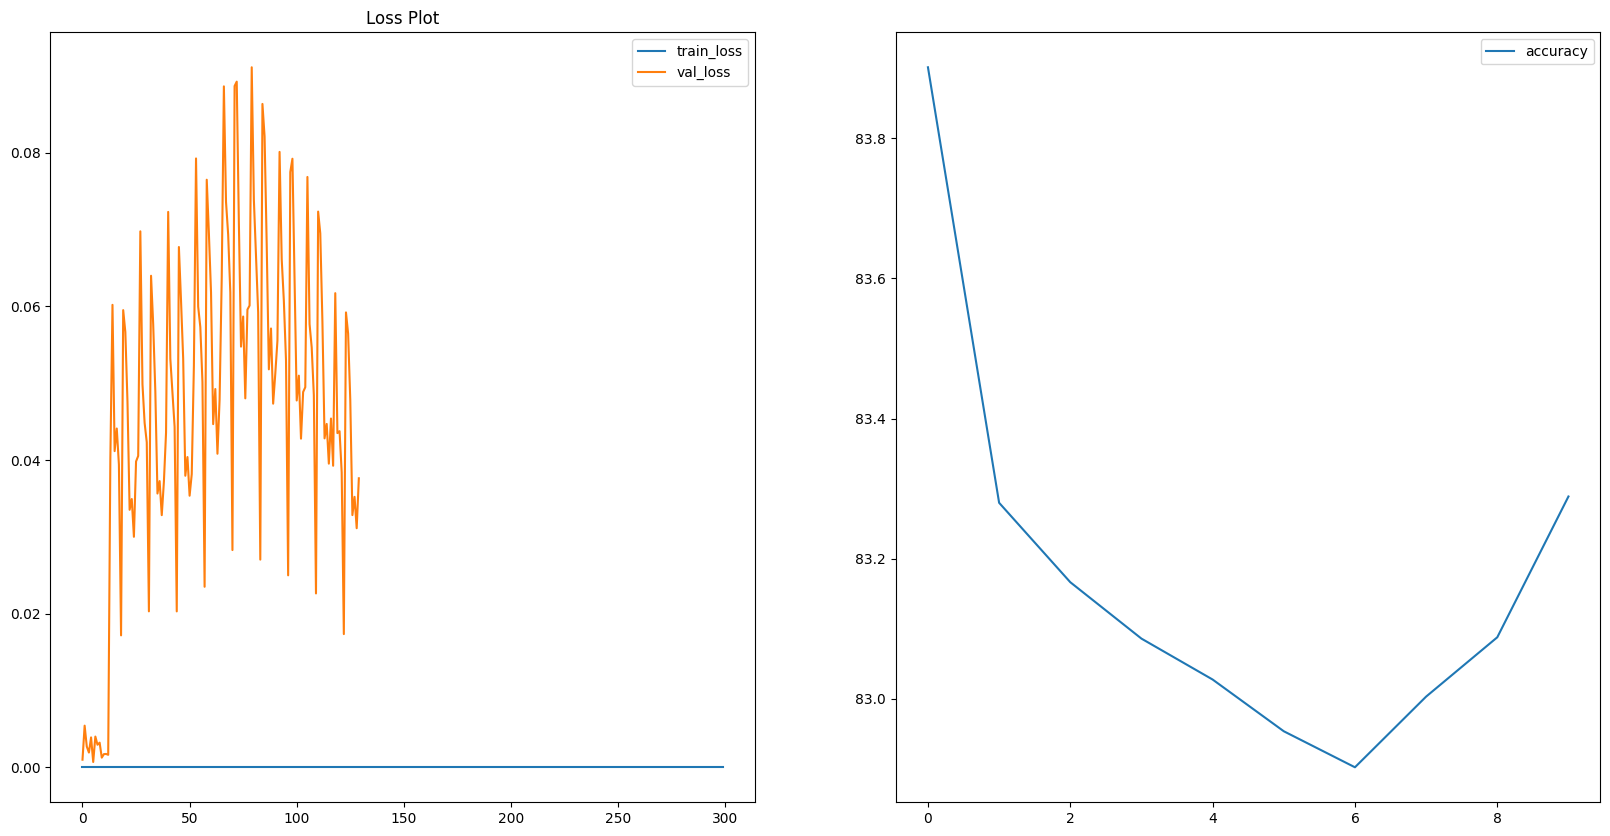

In [21]:
train_loss_cpu = [tensor.cpu().detach().numpy() for tensor in train_loss]
val_loss_cpu = [tensor.cpu().detach().numpy() for tensor in val_loss]
accuracy_list_cpu = [tensor.cpu().detach().numpy() for tensor in accuracy_list]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss_cpu, label='train_loss')
plt.plot(val_loss_cpu, label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(accuracy_list_cpu, label='accuracy')
plt.legend()
plt.show()

In [22]:

def to_mask(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

def to_image(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

In [23]:
# load the model
model, optimizer, start_epoch = load_ckp(CHECKPOINT_PATH, model, optimizer)

In [24]:
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)

model.eval()
# plot the image and mask

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [25]:
image =  image.permute(0, 3, 1, 2).to(device)
# y_pred = model(image)